In [ ]:
!pip install tensorflow  tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZSXM0V/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZSXM0V/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## 2. Viz data and build dataset

In [ ]:
import numpy as np

# set up connection aka iterator
dataiterator = ds.as_numpy_iterator()
# getting data out of pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

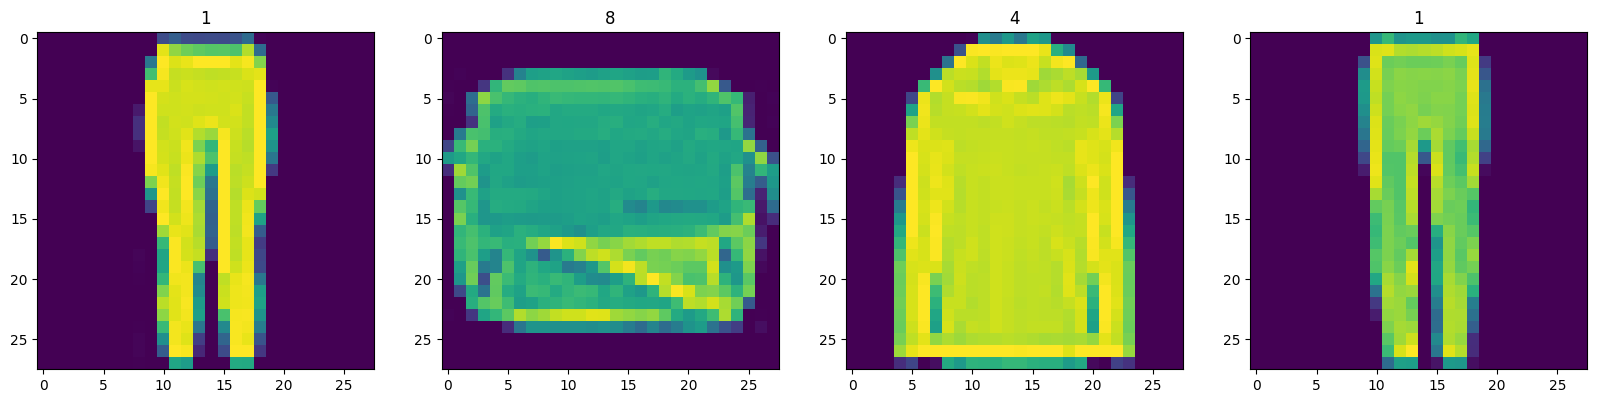

In [ ]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
  #grab an image and label
  sample = dataiterator.next()
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # appending the image label as the plot title
  ax[idx].title.set_text(sample['label'])

In [ ]:
# scale and return images only
def scale_images(data):
  image = data['image']
  return image / 255

In [ ]:
ds = tfds.load('fashion_mnist', split='train')
# running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# batch into 128 images per sample
ds = ds.batch(128)
# reduce the liklihood of bottlencking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3. Build the Neural Network

### 3.1 Import modelling components

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build generator

In [ ]:
from keras.src.metrics.confusion_metrics import activations
def build_generator():
  model = Sequential()

  # takes in random values and reshapes it to 7x7x128
  #beginnings of a renerated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))


  return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [ ]:
img = generator.predict(np.random.randn(4, 128,  1))
img

1/1 [==============================] - 8s 8s/step


array([[[[0.50079125],
         [0.5015058 ],
         [0.50511086],
         ...,
         [0.5020695 ],
         [0.5042408 ],
         [0.4999105 ]],

        [[0.5061048 ],
         [0.5021242 ],
         [0.49968395],
         ...,
         [0.5063609 ],
         [0.50497967],
         [0.50064874]],

        [[0.5029317 ],
         [0.5032961 ],
         [0.5079435 ],
         ...,
         [0.5030893 ],
         [0.5003303 ],
         [0.4993886 ]],

        ...,

        [[0.5037622 ],
         [0.4958512 ],
         [0.49555013],
         ...,
         [0.49612555],
         [0.4958329 ],
         [0.4990226 ]],

        [[0.51063675],
         [0.50252694],
         [0.5007271 ],
         ...,
         [0.5011286 ],
         [0.4974938 ],
         [0.4994061 ]],

        [[0.5031835 ],
         [0.49907202],
         [0.4979905 ],
         ...,
         [0.50275093],
         [0.5014094 ],
         [0.50055087]]],


       [[[0.49769893],
         [0.4990035 ],
         [0.50

In [ ]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 22ms/step


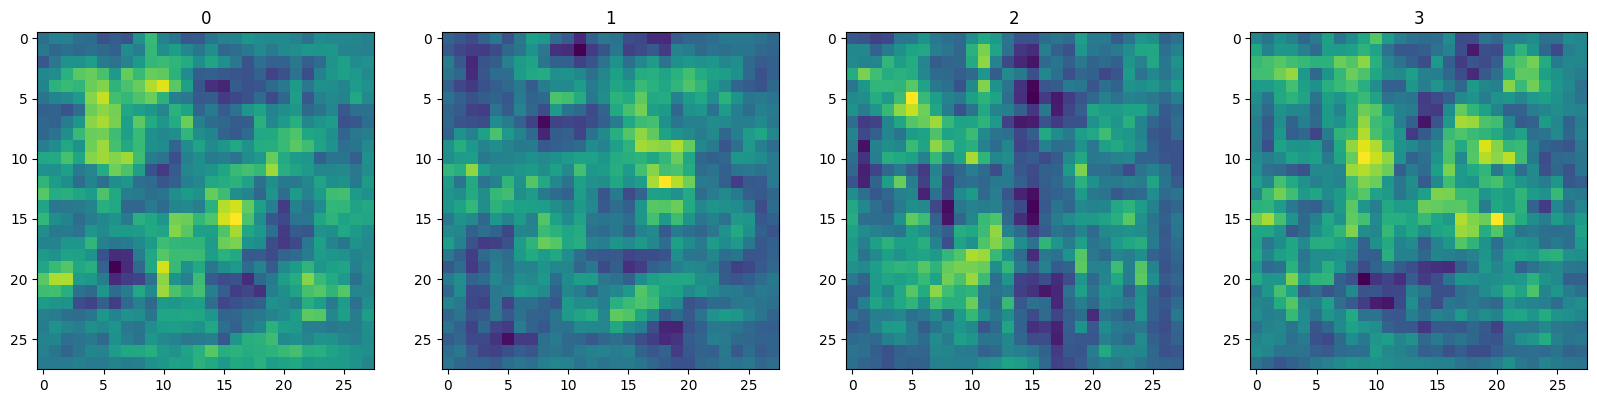

In [ ]:
# generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(img):
  # plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # appending the image label as the plot title
  ax[idx].title.set_text(idx)

### 3.3 Build discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  # first conv block
  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # fourth conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = generator.predict(np.random.randn(4, 128, 1))

1/1 [==============================] - 0s 19ms/step


In [ ]:
img.shape

(4, 28, 28, 1)

In [ ]:
discriminator.predict(img)

1/1 [==============================] - 0s 197ms/step


array([[0.4943959 ],
       [0.49455726],
       [0.49457902],
       [0.49466148]], dtype=float32)

In [ ]:
img = img[0]
img.shape

(28, 28, 1)

In [ ]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 125ms/step


array([[0.4943959]], dtype=float32)

## 4. Construct training loop

### 4.1 Setup losses and optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 build subclassed model

In [ ]:
# importing the base model calss to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 9.63563144e-01],
        [-3.19800353e+00],
        [-3.24209356e+00],
        [-1.71790361e-01],
        [-1.02724157e-01],
        [ 2.75343084e+00],
        [-1.20876563e+00],
        [-5.10169625e-01],
        [ 2.91235030e-01],
        [-2.06711772e-03],
        [-1.19870365e+00],
        [ 1.32515264e+00],
        [-9.06204402e-01],
        [-1.20517242e+00],
        [ 4.10746515e-01],
        [-6.90851510e-01],
        [ 4.00016129e-01],
        [ 6.65116534e-02],
        [-2.25802612e+00],
        [ 1.89994717e+00],
        [ 1.52310953e-02],
        [-6.39117211e-02],
        [ 1.48963287e-01],
        [-1.15160978e+00],
        [ 1.78316966e-01],
        [-6.05548620e-01],
        [ 2.16344690e+00],
        [ 3.95563133e-02],
        [-1.10852468e+00],
        [-1.73986518e+00],
        [-1.53880239e+00],
        [-6.04916215e-01],
        [ 1.29831374e+00],
        [-2.23133698e-01],
        [ 6.47227287e-01],
  

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)

    # create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)), training=False)

    # train the discriminator
    with tf.GradientTape() as d_tape:
      # pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake imaged
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # add some noise to the true output
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calculate loss - BInaryCross
      total_d_loss = self.d_loss(yhat_realfake, yhat_realfake)

    # apply backprppagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


    # train the generator
    with tf.GradientTape() as g_tape:

      # generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # create the predicted labels
      predicted_labels = self.discriminator(gen_images, training=True)

      # calculate loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss":total_g_loss}

In [ ]:
# create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [46]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/images1/', f'generated_img_{epoch}_{i}.png'))


In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filename
checkpoint_path = '/content/generator_weights.h5'

# Create a ModelCheckpoint callback to save the weights
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',  # Choose a suitable metric to monitor
    mode='min'  # Choose 'min' or 'max' depending on the monitored metric
)


### 4.4 Train

In [ ]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor(), checkpoint_callback])

Epoch 1/20
  6/469 [..............................] - ETA: 1:15 - d_loss: 3.8742e-10 - g_loss: 0.0000e+00

469/469 [==============================] - ETA: 0s - d_loss: 4.8768e-10 - g_loss: 0.0000e+00

469/469 [==============================] - 78s 166ms/step - d_loss: 4.8664e-10 - g_loss: 0.0000e+00
Epoch 2/20
438/469 [===========================>..] - ETA: 5s - d_loss: 5.5909e-10 - g_loss: 0.0000e+00

### 4.2 Review the performance

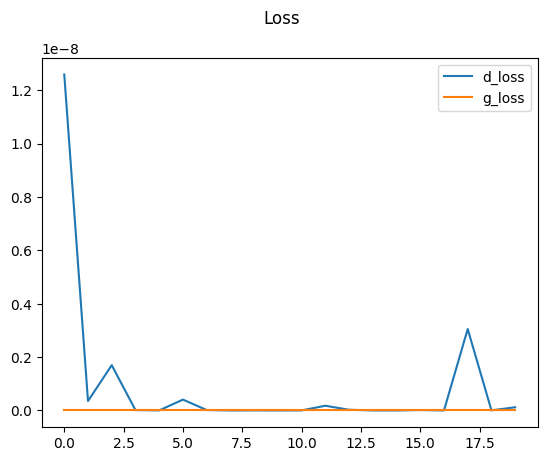

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## 5. Test out generator

### 5.1 Generate images

In [ ]:
generator.load_weights(os.path.join('generatormodel.h5'))

ValueError: ignored

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 371ms/step


In [ ]:
img

array([[[0.5036917 ],
        [0.49795985],
        [0.5050565 ],
        [0.5011551 ],
        [0.49958444],
        [0.5056896 ],
        [0.5033904 ],
        [0.49686795],
        [0.4964685 ],
        [0.5031306 ],
        [0.5026808 ],
        [0.5014564 ],
        [0.50665516],
        [0.50209373],
        [0.507137  ],
        [0.5027251 ],
        [0.5062148 ],
        [0.4985399 ],
        [0.4987603 ],
        [0.5011248 ],
        [0.5036226 ],
        [0.5015076 ],
        [0.50271827],
        [0.5031011 ],
        [0.5061238 ],
        [0.50882584],
        [0.5074509 ],
        [0.501534  ]],

       [[0.50181484],
        [0.49850768],
        [0.5044299 ],
        [0.50705326],
        [0.5095896 ],
        [0.5122024 ],
        [0.5106144 ],
        [0.5014627 ],
        [0.50552356],
        [0.5120057 ],
        [0.50803906],
        [0.5033322 ],
        [0.5024652 ],
        [0.49649215],
        [0.50748646],
        [0.50487876],
        [0.5075701 ],
        

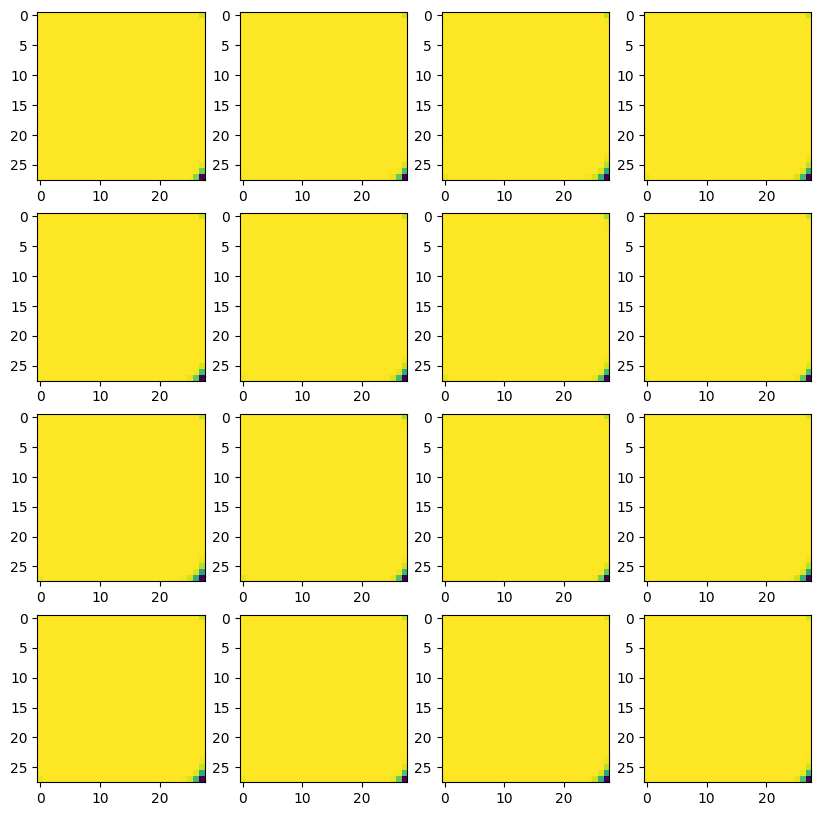

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])